In [1]:
#import numpy, pandas, matplotlib, amazon data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data=pd.read_csv('Data/Amazon.csv')
data.drop('Index',axis=1,inplace=True)

In [3]:
data.rename(columns={'ScrapedIndex':'Index',
                     'ScrapedIndexTrueRank':'RankNoShip',
                     'CorrectedIndexTrueRank':'RankWithShip',
                     'ScrapedIndexPrice':'ScrapedPrice',
                     'ScrapedIndexVendor':'Vendor',
                     'ScrapedIndexVendorType':'VendorType',
                    }, inplace=True)

In [4]:
data.head()

,ProductName,ScrapeDate,Index,RankNoShip,RankWithShip,ScrapedPrice,CorrectedPrice,Vendor,VendorType,BBScrapedPrice,BBVendorType,BBVendor,BBCorrectedPrice
0,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,2,2,1,20.99,20.99,Supplement Warriors,Other,-1.0,FBA,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02
1,#1 BEST Probiotic Supplement - 60 Day Supply w...,2016-06-14,1,1,2,19.99,25.02,Sharp Nutrition,FBA,-1.0,FBA,Sold by Sharp Nutrition and Fulfilled by Amazon.,25.02
2,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,1,1,1,3.96,3.96,speedy tests,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97
3,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,2,1,1,3.96,3.96,Drug Abuse Control,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97
4,"10 Panel Dip Drug Testing Kit, Test for 10 Dif...",2016-06-27,3,1,1,3.96,3.96,Lowest Priced Tests,Other,4.9,FBA,Sold by Michael Minyety and Fulfilled by Amazon.,9.97


In [5]:
data['BBVendor'].isnull().sum()/len(data) #2.3% of bbvendor is null, will fill with mode

0.02351928868492758

In [6]:
data['BBVendor'].value_counts() #most of data is is 'Ships from and sold by Amazon.com', so I will allocate null BBVendor values to the mode

Ships from and sold by Amazon.com.                              5293
Ships from and sold by Amazon.com in easy-to-open packaging.     495
Ships from and sold by El Garaje.                                 86
Ships from and sold by PORTABLE GUY.                              46
Ships from and sold by ShopChanute.                               44
                                                                ... 
Sold by Pure Water Supplier and Fulfilled by Amazon.               3
Ships from and sold by Nutrition Depot.                            2
Sold by Store4PC and Fulfilled by Amazon.                          2
Sold by power-innovation and Fulfilled by Amazon.                  2
Sold by Sharp Nutrition and Fulfilled by Amazon.                   2
Name: BBVendor, Length: 62, dtype: int64

In [7]:
#I also noticed that "Ships from and sold by Amazon.com in easy-to-open packaging" is the same as "Ships from and sold by Amazon.com.""
data['BBVendor'].replace({'Ships from and sold by Amazon.com in easy-to-open packaging.':'Ships from and sold by Amazon.com.'})
data['BBVendor'].value_counts()
                         
                         
                         

Ships from and sold by Amazon.com.                              5293
Ships from and sold by Amazon.com in easy-to-open packaging.     495
Ships from and sold by El Garaje.                                 86
Ships from and sold by PORTABLE GUY.                              46
Ships from and sold by ShopChanute.                               44
                                                                ... 
Sold by Pure Water Supplier and Fulfilled by Amazon.               3
Ships from and sold by Nutrition Depot.                            2
Sold by Store4PC and Fulfilled by Amazon.                          2
Sold by power-innovation and Fulfilled by Amazon.                  2
Sold by Sharp Nutrition and Fulfilled by Amazon.                   2
Name: BBVendor, Length: 62, dtype: int64

In [8]:
import statistics
data['BBVendor']=data['BBVendor'].fillna(statistics.mode(data['BBVendor'])) #FILLING NULL WITH BBVENDOR MODE

In [9]:
#checking nulls again
data.isnull().sum() 

ProductName         0
ScrapeDate          0
Index               0
RankNoShip          0
RankWithShip        0
ScrapedPrice        0
CorrectedPrice      0
Vendor              0
VendorType          0
BBScrapedPrice      0
BBVendorType        0
BBVendor            0
BBCorrectedPrice    0
dtype: int64

In [10]:
data.dtypes #Most things are correct, besides that ScrapeDate should be date/time if we want to work with it

ProductName          object
ScrapeDate           object
Index                 int64
RankNoShip            int64
RankWithShip          int64
ScrapedPrice        float64
CorrectedPrice      float64
Vendor               object
VendorType           object
BBScrapedPrice      float64
BBVendorType         object
BBVendor             object
BBCorrectedPrice    float64
dtype: object

In [11]:
data['ScrapeDate'] = pd.to_datetime(data['ScrapeDate']) #changing ScrapeDate dtype 

In [12]:
#How many unique products are there? #(count: 250)
len(data['ProductName'].value_counts()) 

250

In [13]:
#How many unique vendors are there? #(count: 2892)
len(data['Vendor'].value_counts())

2892

In [14]:
data['BBVendorType'].value_counts() #FBA (count: 470)is where you ship your inventory to Amazon and they fulfill each order as it comes in 
#O is other, likely 3rd party (count: 715)
#Amazon would be themselves as the seller (count: 5788)

#However, per product, the buybox vendor per line does not change and repeats, 
#so we'll look at this again later to see the true percentage of amazon/O/FBA sellers

Amazon    5788
O          715
FBA        470
Name: BBVendorType, dtype: int64

In [15]:
#How many listings per product are there? 
#Making a column 'Count' with new DataFrame NumProducts
#First, grouping data by 'ProductName', then counting the number of columns on any of the other levels
#in my case, i just chose the column next to it, 'ScrapeDate' and counted the number times it appeared 
#I then changed the name of the column to 'Count'
#Then, I reset the index so I can merge it into Data
NumProducts = pd.DataFrame(data.groupby('ProductName')['ScrapeDate'].count().rename(columns={'ScrapeDate':'Count'}))
NumProducts = NumProducts.reset_index()

In [16]:
#Merge NumProducts, left_on and right_on ProductName because the columns are the same, default how=left
data = data.merge(NumProducts, left_on='ProductName',right_on='ProductName')

In [17]:
#renaming column so it makes more sense
data.rename(columns={
    0:'NumListings'}, inplace=True)

In [18]:
#I noticed that BBScrapedPrice had many -1.00s (count:358), so I wanted to see if I could replace it with 
#BBCorrectedPrice (BBScrapedPrice+Shipping), on the basis that there were many listings with free shipping. 

In [19]:
#checking shipping for scraped items
#First I made a new column IndexShippingPrice to show shipping prices of all scraped items
data['IndexShippingPrice'] = data['CorrectedPrice'] - data['ScrapedPrice']

In [20]:
#now check how many had free shipping
data['IndexShippingPrice'].value_counts() #6372 of the Indexed products had free shipping. 

0.00     6372
5.48       21
6.50       13
5.48       11
6.36        9
         ... 
8.59        1
7.08        1
13.84       1
7.00        1
5.55        1
Name: IndexShippingPrice, Length: 305, dtype: int64

In [21]:
#repeat with BuyBox products
#I made a new column BBShip to show shipping prices of all BuyBox items
data['BBShip']=data['BBCorrectedPrice'] - data['BBScrapedPrice'] 

In [22]:
data['BBShip'].value_counts() #527 free shipping

0.00     527
5.07     171
5.48     169
6.64     122
23.90    115
        ... 
0.99       2
7.65       2
24.27      2
71.88      1
16.27      1
Name: BBShip, Length: 194, dtype: int64

In [23]:
data[data['BBShip']<1] #527 were free shipping, 633 were less than $1.00

,ProductName,ScrapeDate,Index,RankNoShip,RankWithShip,ScrapedPrice,CorrectedPrice,Vendor,VendorType,BBScrapedPrice,BBVendorType,BBVendor,BBCorrectedPrice,NumListings,IndexShippingPrice,BBShip
21,3 Pair Motorcycle Riding Glasses Smoke Clear Y...,2016-08-29,1,1,1,6.79,6.79,Happy DRH,Other,6.79,O,Ships from and sold by Happy DRH.,6.79,9,0.00,0.0
22,3 Pair Motorcycle Riding Glasses Smoke Clear Y...,2016-08-29,4,3,2,8.97,8.97,MODA Eyewear,Other,6.79,O,Ships from and sold by Happy DRH.,6.79,9,0.00,0.0
23,3 Pair Motorcycle Riding Glasses Smoke Clear Y...,2016-08-29,5,4,3,12.48,12.48,MyLux Connection,Other,6.79,O,Ships from and sold by Happy DRH.,6.79,9,0.00,0.0
24,3 Pair Motorcycle Riding Glasses Smoke Clear Y...,2016-08-29,6,5,4,13.89,13.89,OnlineWelcome,Other,6.79,O,Ships from and sold by Happy DRH.,6.79,9,0.00,0.0
25,3 Pair Motorcycle Riding Glasses Smoke Clear Y...,2016-08-29,8,7,5,14.68,14.68,VeryHobby,Other,6.79,O,Ships from and sold by Happy DRH.,6.79,9,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6603,The North Face Unisex Borealis Backpack,2016-09-02,15,15,14,119.98,119.98,shopit,Other,88.95,O,Ships from and sold by Clothing & Shoes.,88.95,18,0.00,0.0
6604,The North Face Unisex Borealis Backpack,2016-09-02,16,16,15,121.51,121.51,Gray Fox.,Other,88.95,O,Ships from and sold by Clothing & Shoes.,88.95,18,0.00,0.0
6605,The North Face Unisex Borealis Backpack,2016-09-02,14,14,16,114.00,123.71,All great deals,FBA,88.95,O,Ships from and sold by Clothing & Shoes.,88.95,18,9.71,0.0
6606,The North Face Unisex Borealis Backpack,2016-09-02,17,17,17,137.42,137.42,Twinix Store,Other,88.95,O,Ships from and sold by Clothing & Shoes.,88.95,18,0.00,0.0


In [24]:
#Since free shipping was the mode of both buybox and indexed items, 
#i set the price of BBScrapedPrice when it was -1 equal to the BBCorrectedPrice
data['BBScrapedPrice']=np.where(data['BBScrapedPrice']==-1.00, data['BBCorrectedPrice'], data['BBScrapedPrice'])


In [26]:
#Explore: difference between Index, RankWithShip, RankNoShip

x = data[data['ProductName'] == 'Fujifilm INSTAX Mini Instant Film (Rainbow)'][['Index', 'RankNoShip', 'RankWithShip','ScrapedPrice', 'CorrectedPrice', 'VendorType']]
x.sort_values('Index').head(20)

#from here we can see: 
#RankNoShip is dependent on the scraped price, ordered, which is why there are repeating numbers
#RankWithShip is dependent on the price, which is why there are repeating numbers 
#Index ranks based on ScrapedPrice, but also weighs the vendortype
#for the first two prices, we see that ScrapedPrice is 8.99, but Amazon is ranked above FBA and Other with the same ScrapedPrice
    #this gives me the impression that Amazon as a vendor is ranked above Other and FBA vendors 
    #despite having the same ScrapedPrice and higher Shipping rates 

    

,Index,RankNoShip,RankWithShip,ScrapedPrice,CorrectedPrice,VendorType
2579,1,1,14,8.99,14.06,Amazon
2580,2,1,14,8.99,14.06,FBA
2554,3,2,1,8.99,8.99,Other
2555,4,2,1,8.99,8.99,Other
2556,5,3,2,9.54,9.54,Other
2590,6,4,24,9.95,15.02,FBA
2595,7,5,29,10.99,16.06,FBA
2557,8,6,3,11.00,11.00,Other
2597,9,7,31,11.40,16.47,FBA
2558,10,8,4,11.45,11.45,Other


In [27]:
#Explore: % of each type of vendor featured in the buybox

BB = data[['ProductName','BBScrapedPrice','BBVendorType','BBVendor','BBCorrectedPrice','BBShip']]
pd.DataFrame(BB.groupby('ProductName')['BBVendorType'].value_counts())

BB.drop_duplicates(keep='first', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
BB['BBVendorType'].value_counts()

#Amazon Counts: 180
#O Counts: 36
#FBA Counts: 34 

Amazon    180
O          36
FBA        34
Name: BBVendorType, dtype: int64

In [29]:
BB['BBVendorType'].value_counts()['Amazon']/len(BB) #72% of buybox were Amazon

0.72

In [30]:
BB['BBVendorType'].value_counts()['O']/len(BB) #14.4% of buybox were 'Other'

0.144

In [31]:
BB['BBVendorType'].value_counts()['FBA']/len(BB) #13.6% of buybox were 'FBA'

0.136

In [32]:
#Explore: % of each type of vendor 

data['VendorType'].value_counts()

Other     6372
FBA        409
Amazon     192
Name: VendorType, dtype: int64

In [33]:
data['VendorType'].value_counts()['Other']/len(data) #91.38% of index were 'Other'

0.9138104115875519

In [34]:
data['VendorType'].value_counts()['Amazon']/len(data) #2.75% of index were 'AMAZON'

0.027534776996988385

In [35]:
data['VendorType'].value_counts()['FBA']/len(data) #5.87% of index were 'FBA'

0.05865481141545963

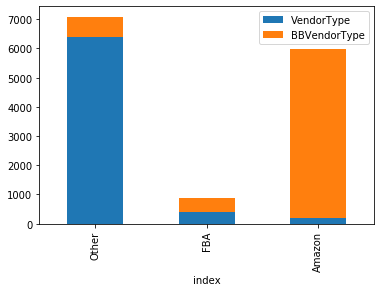

In [36]:
#VISUALIZATION BTWN VENDORTYPES//STACKED BAR CHARTS
vendortype=pd.DataFrame(data['VendorType'].value_counts()) #save each of the valuecounts for vendortype to a dataframe
bbvendortype=pd.DataFrame(data['BBVendorType'].value_counts()) #same for BB
vendortype = vendortype.reset_index() #reset the index
bbvendortype= bbvendortype.reset_index()
bbvendortype.replace({'O':'Other'},inplace=True) #change O to other so names are consistent 

viz1=vendortype.merge(bbvendortype,left_on='index', right_on='index') #merge to have one dataframe 
viz1x=viz1['index'].tolist() #get the x axis by putting it in a list 
viz1.plot(x='index', y=['VendorType', 'BBVendorType'], kind='bar', stacked=True); #plot! 

In [62]:
#looping through each row and seeing if the vendor name was in the 'BBVendor' text, which meant it was the buybox 
#this column will help determine if a new vendor would be in the buybox
for idx, row in data.iterrows():
    if (row['Vendor'] in row['BBVendor']):
        data.loc[idx, 'isbuybox?'] = 1
    else:
        data.loc[idx, 'isbuybox?'] = 0

In [38]:
data['isbuybox?'].value_counts()

0.0    6719
1.0     254
Name: isbuybox?, dtype: int64

In [63]:
 #% off of the price from the buybox price (w/o shipping)
data['PctOffNoShip'] = (data['ScrapedPrice']-data['BBScrapedPrice'])/data['BBScrapedPrice']
 #% off of the price from the buybox price (w/ shipping)
data['PctOffShip'] = (data['CorrectedPrice']-data['BBCorrectedPrice'])/data['BBCorrectedPrice']

In [40]:
#Getting infinity for weber grill cleaner spray because its buybox values are equal to 0 
#Since there are only 20 listings, I dropped Weber from the dataset
#first i made a variable equal to the list of every index with the Weber product
weber = data[data['ProductName'] == 'Weber Grill Cleaner Spray - Professional Strength Degreaser - Non Toxic 16 oz Cleanser'].index.tolist()

In [41]:
#then i dropped it by locating with index
data = data.drop(data.index[weber])

In [64]:
#Visualization for percent away from the buybox price (with shipping and no shipping)
pctoff = pd.DataFrame(data.groupby('ProductName')[['PctOffNoShip','PctOffShip']].mean()).reset_index().drop('ProductName',axis=1)
pctoff = pctoff.reset_index()
yaxis=pctoff[['PctOffNoShip','PctOffShip']]

#this is the dataframe that will be visualized
pctoff

,index,PctOffNoShip,PctOffShip
0,0,-0.181055,-0.080536
1,1,1.215126,0.148504
2,2,3.761284,3.761284
3,3,0.697595,1.020128
4,4,0.224361,0.240806
...,...,...,...
244,244,0.270758,0.083819
245,245,0.774739,0.085682
246,246,0.792764,0.256842
247,247,-0.056174,0.276974


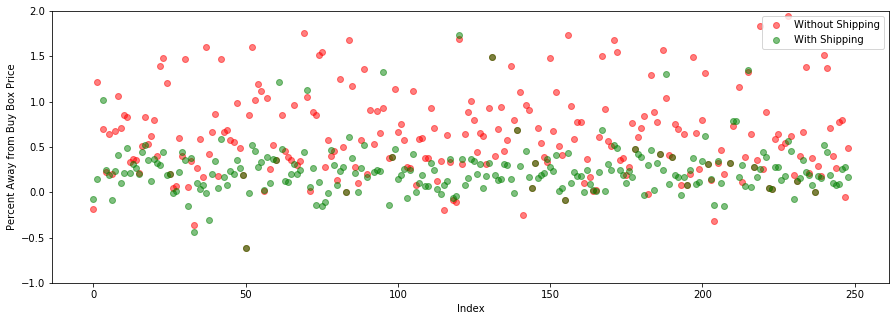

In [44]:
#pctoff.plot(x='index', y=['PctOffNoShip','PctOffShip'],kind='scatter', stacked=True)
plt.figure(figsize=(15, 5))
plt.scatter(pctoff['index'], y=pctoff['PctOffNoShip'], color='red', alpha=.5, label='Without Shipping')
plt.scatter(pctoff['index'], y=pctoff['PctOffShip'], color='green', alpha=.5, label='With Shipping')
plt.xlabel('Index')
plt.ylabel('Percent Away from Buy Box Price')
plt.ylim(-1,2)
plt.legend()
plt.show()

#this plots percent away from the buybox price, both including shipping (green) and without shipping (red)
#from this plot, we can see that without shipping, the numbers without shipping, were higher (generally) 
#however when shipping was accounted for, prices lingered closer to zero and sometimes even went below 0,
#indicating that lower prices with shipping were not selected for the buy box

CATEGORICAL 
    - ProductName, Vendor, VendorType, BBVendorType, BBVendor, isbuybox?

NUMERICAL 
    continuous 
        - ScrapedPrice, CorrectedPrice, BBScrapedPrice, BBCorrectedPrice, IndexShippingPrice, BBShip, PctOffNoShip, PctOffShip
    ordinal 
        - ScrapeDate, Index, RankNoShip, RankWithShip, NumListings

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split

In [46]:
rf = RandomForestRegressor()
ohe = OneHotEncoder()
pipe = make_pipeline(ohe, rf)

In [47]:
data = data.drop('ScrapeDate',axis=1)
X = data.drop('isbuybox?',axis=1)
y= data['isbuybox?']

In [48]:
#make the training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [49]:
#now to fit the training data 
pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['ProductName', 'Vendor', 'VendorType',
                                     'BBVendorType', 'BBVendor'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jo

In [50]:
pipe.score(X_train, y_train) #training score = 0.9831851281887842

0.9834383642100376

In [51]:
pipe.score(X_test, y_test) #test score = 0.8742006391164061, which means variance is low and it is underfitting and high bias

0.8877947381484239

In [52]:
#next, Grid Search to improve score
from sklearn.model_selection import GridSearchCV

params = {
    'randomforestregressor__min_samples_leaf': [5,10,15,25],
    'randomforestregressor__max_features': [0.3, 0.4, 0.5],
    'randomforestregressor__n_estimators': [10, 50, 100]
}

grid = GridSearchCV(estimator=pipe, param_grid=params, cv=5)

In [53]:
#fit the grid
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=['ProductName',
                                                            'Vendor',
                                                            'VendorType',
                                                            'BBVendorType',
                                                            'BBVendor'],
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      return_df=True,
                                                      use_cat_names=False,
                                                      verbose=0)),
                                  

In [54]:
#getting the best parameters from grid search
grid.best_params_ 
#this returned
#{'randomforestregressor__max_features': 0.5,
# 'randomforestregressor__min_samples_leaf': 5, 
# 'randomforestregressor__n_estimators': 100}


{'randomforestregressor__max_features': 0.5,
 'randomforestregressor__min_samples_leaf': 5,
 'randomforestregressor__n_estimators': 50}

In [55]:
#setting new parameters based on grid serach 
pipe.steps[1][1].set_params(n_estimators=100, min_samples_leaf=5, max_features=0.5, random_state=2020)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=2020,
                      verbose=0, warm_start=False)

In [56]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['ProductName', 'Vendor', 'VendorType',
                                     'BBVendorType', 'BBVendor'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features=0.5,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=5, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs

In [57]:
pipe.score(X_train, y_train) #training score: 0.9217425395261368

0.9217425395261368

In [58]:
pipe.score(X_test, y_test) #testing score: 0.8487558999376412 

#While the test stcore is still underfitting, the score improved!!!!!!!!!!  

0.8487558999376412

In [59]:
pipe

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['ProductName', 'Vendor', 'VendorType',
                                     'BBVendorType', 'BBVendor'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features=0.5,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=5, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs

In [60]:
#pickle file 
import pickle 

In [61]:
with open('amazon.pkl','wb') as file:
    pickle.dump(pipe, file)
    file.close()